In [ ]:
#ipynb to produce a csv for the left and right heelstrike and toeoff events given a list of trials. 

In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
from torch.utils.data import Dataset, DataLoader
import scipy

import matplotlib.animation as animation
import matplotlib.colors as mcolors

from collections import defaultdict

from matplotlib.animation import FuncAnimation
import cv2 as cv

In [ ]:
# stroke 0.75, normal 0.6
# gait_recording_021925_walk11.mat	02.19.2025	Stroke Patient (Right leg paretic)	0.75	0.75

# normal split at different speeds

# gait_recording_080624_walk.mat	08.06.2024	Junjun	0.6	0.6
# gait_recording_080624_walk2.mat	08.06.2024	Junjun	0.6	1
# gait_recording_080624_walk3.mat	08.06.2024	Junjun	0.6	1.8
# gait_recording_080624_walk4.mat	08.06.2024	Junjun	0.6	1.4
# gait_recording_080624_walk5.mat	08.06.2024	Junjun	1	0.6
# gait_recording_080624_walk6.mat	08.06.2024	Junjun	1.4	0.6
# gait_recording_080624_walk7.mat	08.06.2024	Junjun	1.8	0.6


trial_list = [ "gait_recording_021925_walk2.mat",
               "gait_recording_080624_walk.mat", 
             "gait_recording_080624_walk2.mat", 
             "gait_recording_080624_walk3.mat", 
             "gait_recording_080624_walk4.mat", 
             "gait_recording_080624_walk5.mat", 
             "gait_recording_080624_walk6.mat", 
             "gait_recording_080624_walk7.mat", 
            ]

data = {}

In [57]:
def segment_insole_data(insole_data):
    toe_region = insole_data[:, :13, :]  # Toe
    forefoot_region = insole_data[:, 13:31, :]  # Forefoot
    midfoot_region = insole_data[:, 32:42, :]  #  Midfoot
    heel_region = insole_data[:, 42:, :]  #  Heel
    return heel_region, midfoot_region, forefoot_region, toe_region

def butter_lowpass_filter(data, cutoff=8, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, 64, 16), dtype=data.dtype)
    for i in range(num_frames):
        frame = data[i].reshape(16, 64).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame

    return reshaped_data

def gait_segmentation(insole, h_th, t_th, ms_th):

    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_insole = (insole > 25).astype(int)

    p_heel_filtered = butter_lowpass_filter(p_heel, 8, 75)
    p_fore_filtered = butter_lowpass_filter(p_forefoot+p_toe, 8, 75)
    p_foot_filtered = butter_lowpass_filter(np.sum(insole, axis=(1, 2)), 8, 75)

    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)

    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=10)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=10)
    ms_indices, _ = find_peaks(p_foot_filtered, height=ms_th, distance=30)
    
    return hc_indices, to_indices, ms_indices, p_heel_derivative, p_fore_derivative



def resample_data(data):
    n = data.shape[0]
    index = np.linspace(0, 100, n)
    target = np.linspace(0, 100, 100)
    resampled_data = np.zeros((100, 3))
    for i in range(3):
        interp_func = interp1d(index, data[:, i])
        resampled_data[:, i] = interp_func(target)

    return resampled_data


def get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds):
    """
    Get gait parameters from insole data
    """

    [h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] = thresholds

    gait = {'foot_trace_r': np.zeros(len(t_r)), 'foot_trace_l': np.zeros(len(t_l)),
            'dim': [int(np.sqrt(insole_r.shape[1]) * 2), int(np.sqrt(insole_r.shape[1]) / 2)],
            'cop_x_r': np.zeros(len(t_r)),
            'cop_y_r': np.zeros(len(t_r)),
            'cont_area_r': np.zeros(len(t_r)),
            'cop_x_l': np.zeros(len(t_l)),
            'cop_y_l': np.zeros(len(t_l)),
            'cont_area_l': np.zeros(len(t_l)),
            }
    insole_data = {'insole_r_flipped':[],
            'insole_l_flipped':[]}
    
    pressures = {}

    for i in range(len(t_r)):
        frame = insole_r[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        gait['foot_trace_r'][i] = np.mean(frame)
        insole_data['insole_r_flipped'].append(frame)
        x, y = np.where(frame > 0)

        # COP
        sum_frame_r = np.sum(frame[x, y])
        if sum_frame_r > 0:
            gait['cop_x_r'][i] = np.sum(x * frame[x, y]) / sum_frame_r
            gait['cop_y_r'][i] = np.sum(y * frame[x, y]) / sum_frame_r
        else:
            gait['cop_x_r'][i] = np.nan
            gait['cop_y_r'][i] = np.nan

        gait['cont_area_r'][i] = len(x)


    for i in range(len(t_l)):
        frame = insole_l[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        insole_data['insole_l_flipped'].append(frame)
        gait['foot_trace_l'][i] = np.mean(insole_l[i,:])


    # Gait events
    hc_indices, to_indices, ms_indices, p_heel_filtered, p_fore_filtered = gait_segmentation(insole_r, h_th_r, t_th_r, ms_th_r)
    strike_r = sorted(hc_indices)
    off_r = sorted(to_indices)
    ms_r = sorted(ms_indices)
    pressures['heel_r'] = p_heel_filtered
    pressures['toe_r'] = p_fore_filtered

    hc_indices, to_indices, ms_indices, p_heel_filtered, p_fore_filtered = gait_segmentation(insole_l, h_th_l, t_th_l, ms_th_l)
    strike_l = hc_indices
    off_l = to_indices
    ms_l = ms_indices
    pressures['heel_l'] = p_heel_filtered
    pressures['toe_l'] = p_fore_filtered

    # Isolate complete gait cycles
    gait['step_r'] = []
    gait['step_l'] = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        ms = [j for j in ms_r if start <= j <= end]
        if len(step_off) == 1:
            gait['step_r'].append({'strike': [start, end], 'ms': ms,'off': step_off})

    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        ms = [j for j in ms_l if start <= j <= end]

        if len(step_off) == 1:
            gait['step_l'].append({'strike': [start, end], 'ms': ms, 'off': step_off})

    # Cycle duration
    gait['cycle_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['swing_dur_l']= np.zeros((len(gait['step_l'])))
    gait['stance_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['cadence_l'] = np.zeros(len(gait['cycle_dur_l']))
    gait['cycle_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['swing_dur_r']= np.zeros((len(gait['step_r'])))
    gait['stance_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['cadence_r'] = np.zeros(len(gait['cycle_dur_r']))

    for i in range((len(gait['step_l']))):
        start, end = gait['step_l'][i]['strike']
        off = gait['step_l'][i]['off']
        gait['cycle_dur_l'][i] = t_l[end] - t_l[start]
        gait['stance_dur_l'][i] = t_l[off] - t_l[start]
    gait['swing_dur_l'] = gait['cycle_dur_l'] - gait['stance_dur_l']
    gait['stance_phase_l'] = gait['stance_dur_l']/gait['cycle_dur_l']
    gait['swing_phase_l'] = gait['swing_dur_l'] / gait['cycle_dur_l']
    gait['cadence_l'] = 60/gait['cycle_dur_l']

    for i in range((len(gait['step_r']))):
        start, end = gait['step_r'][i]['strike']
        off = gait['step_r'][i]['off']
        gait['cycle_dur_r'][i] = t_r[end] - t_r[start]
        gait['stance_dur_r'][i] = t_r[off] - t_r[start]
    gait['swing_dur_r'] = gait['cycle_dur_r'] - gait['stance_dur_r']
    gait['stance_phase_r'] = gait['stance_dur_r']/gait['cycle_dur_r']
    gait['swing_phase_r'] = gait['swing_dur_r'] / gait['cycle_dur_r']
    gait['cadence_r'] = 60/gait['cycle_dur_r']

    gait['swing_asym'] = np.abs((np.mean(gait['swing_phase_l']) - np.mean(gait['swing_phase_r']))) / (
            0.5 * (np.mean(gait['swing_phase_l']) + np.mean(gait['swing_phase_r'])))

    return gait, insole_data, pressures

gait_recording_021925_walk2.mat


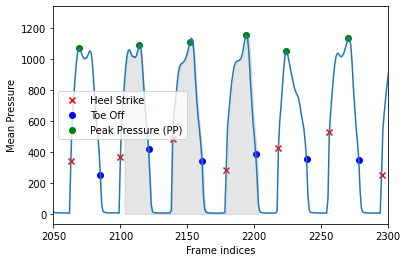

gait_recording_021925_walk2.mat Complete!
gait_recording_080624_walk.mat


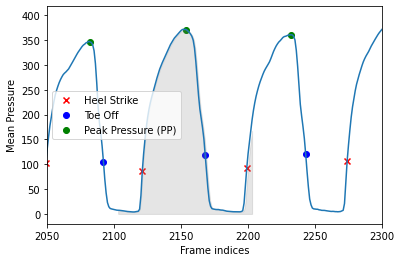

gait_recording_080624_walk.mat Complete!
gait_recording_080624_walk2.mat


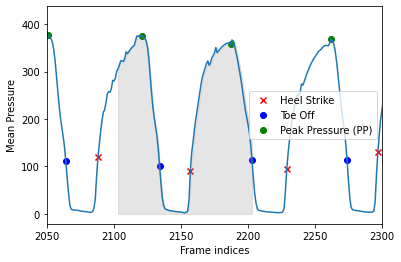

gait_recording_080624_walk2.mat Complete!
gait_recording_080624_walk3.mat


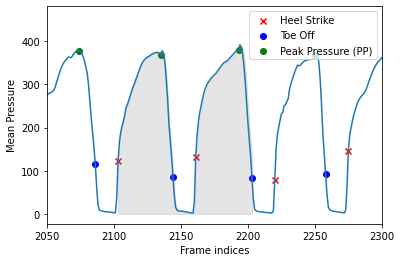

gait_recording_080624_walk3.mat Complete!
gait_recording_080624_walk4.mat


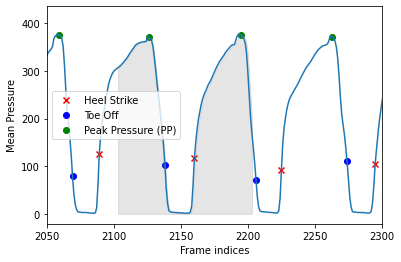

gait_recording_080624_walk4.mat Complete!
gait_recording_080624_walk5.mat


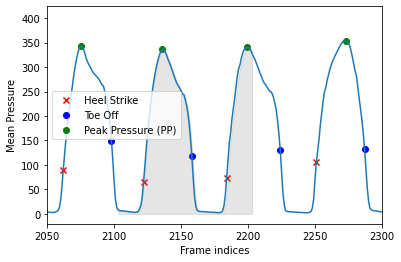

gait_recording_080624_walk5.mat Complete!
gait_recording_080624_walk6.mat


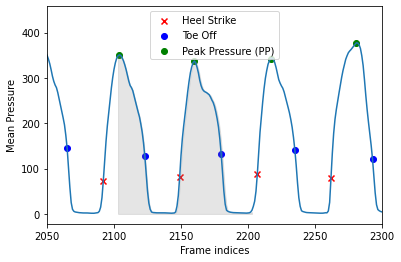

gait_recording_080624_walk6.mat Complete!
gait_recording_080624_walk7.mat


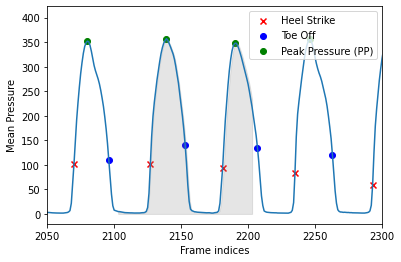

gait_recording_080624_walk7.mat Complete!


In [79]:
for trial in trial_list: 
    print(trial)

    insole_data_path = Path("data")
    insole_data = sio.loadmat(insole_data_path / trial)
    insole_l = insole_data['insoleAll_l']
    insole_r = insole_data['insoleAll_r']
    t_l = insole_data['t_insole_l']
    t_r = insole_data['t_insole_r']
    thresholds = [30, 30, 30,30, 10000,10000, 2, 2] #[h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r]
    if "021925" in trial: 
        thresholds = [100, 100, 100,100, 10000,10000, 2, 2] # thresholds different for stroke patient data
    gait, insole_data, pressures = get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds)
    strike_indices_l = [step['strike'][0] for step in gait['step_l']]
    off_indices_l = [idx for step in gait['step_l'] for idx in step['off']]
    ms_indices_l = [idx for step in gait['step_l'] for idx in step['ms']]
    strike_indices_r = [step['strike'][0] for step in gait['step_r']]
    off_indices_r = [idx for step in gait['step_r'] for idx in step['off']]
    ms_indices_r = [idx for step in gait['step_r'] for idx in step['ms']]
    
    plt.figure()
    plt.plot(gait['foot_trace_l'])
    # Plot 'strike' with 'x' markers

    plt.scatter(strike_indices_l, [gait['foot_trace_l'][idx] for idx in strike_indices_l], 
                color='red', marker='x', label="Heel Strike")

    # Plot 'off' with 'o' markers
    plt.scatter(off_indices_l, [gait['foot_trace_l'][idx] for idx in off_indices_l], 
                color='blue', marker='o', label="Toe Off")

    # Plot 'off' with 'o' markers
    plt.scatter(ms_indices_l, [gait['foot_trace_l'][idx] for idx in ms_indices_l], 
                color='green', marker='o', label="Peak Pressure (PP)")
    plt.legend()
    plt.xlim(2050, 2300)
    plt.fill_between(np.linspace(2103,2203,100), gait['foot_trace_l'][2103:2203], alpha=0.2, color='gray')


    plt.ylabel("Mean Pressure")
    plt.xlabel("Frame indices")
    if "walk3" in trial: 
        # Save the plot as a PNG image
        plt.savefig("walk3.png", dpi=300)
    plt.show()
    
    
    
    trial_name = trial.replace("gait_recording_", "")
    trial_name = trial_name.replace(".mat", "")
    
    data[trial_name+"strike_r"] = strike_indices_r
    data[trial_name+"off_indices_r"] = off_indices_r
    data[trial_name+"strike_l"] = strike_indices_l
    data[trial_name+"off_indices_l"] = off_indices_l
    
    print(f"{trial} Complete!")
    
    
    

In [63]:
df = pd.DataFrame.from_dict(data, orient='index').T

In [64]:
df.head()

,021925_walk2strike_r,021925_walk2off_indices_r,021925_walk2strike_l,021925_walk2off_indices_l,080624_walkstrike_r,080624_walkoff_indices_r,080624_walkstrike_l,080624_walkoff_indices_l,080624_walk2strike_r,080624_walk2off_indices_r,...,080624_walk5strike_l,080624_walk5off_indices_l,080624_walk6strike_r,080624_walk6off_indices_r,080624_walk6strike_l,080624_walk6off_indices_l,080624_walk7strike_r,080624_walk7off_indices_r,080624_walk7strike_l,080624_walk7off_indices_l
0,85.0,109.0,106.0,133.0,359.0,406.0,317.0,370.0,255.0,295.0,...,352.0,390.0,314.0,352.0,286.0,328.0,325.0,358.0,219.0,267.0
1,130.0,152.0,149.0,171.0,435.0,477.0,402.0,443.0,327.0,368.0,...,416.0,452.0,379.0,413.0,348.0,384.0,385.0,417.0,290.0,331.0
2,171.0,191.0,187.0,210.0,506.0,549.0,473.0,516.0,400.0,439.0,...,476.0,513.0,436.0,472.0,410.0,442.0,440.0,478.0,355.0,390.0
3,209.0,234.0,230.0,252.0,578.0,621.0,544.0,587.0,473.0,512.0,...,536.0,570.0,493.0,526.0,470.0,499.0,500.0,533.0,414.0,445.0
4,252.0,271.0,268.0,290.0,651.0,693.0,617.0,661.0,545.0,583.0,...,602.0,633.0,550.0,586.0,523.0,556.0,553.0,584.0,473.0,503.0


In [65]:
df.to_csv("strikeandoffindices.csv", index=False)